# Self Organized Maps (SOMs)

## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np
import pandas as pd

# MiniSOM
from minisom import MiniSom

# XPySOM
from xpysom import XPySom

# SimpSOM, https://simpsom.readthedocs.io
import simpsom as sps
# from simpsom.plots import scatter_on_map

# Astropy
from astropy.table import Table

In [22]:
# from psutil import *
# # This code will return the number of CPU
# print("Number of CPU: ", cpu_count())
# # This code will return the CPU info
# !cat /proc/cpuinfo

## Import catalog

In [3]:
emu_matched_catalog_path = '/data/mfonseca/cross_match/EMU_0102-32/EMU_0101-32_DES_VIKING_CATWISE/EMU_0102-32_DES_VIKING_CATWISE.fits'
emu_matched_catalog = Table.read(emu_matched_catalog_path)
emu_matched_catalog = emu_matched_catalog.to_pandas()

In [4]:
emu_matched_catalog.describe()

,EMU_n_components,EMU_ra_deg_cont,EMU_dec_deg_cont,EMU_freq,EMU_maj_axis,EMU_min_axis,EMU_pos_ang,EMU_flux_int,EMU_flux_int_err,EMU_flux_peak,...,bias_CAT_w2mpro,p_single,p_any,p_i,match_flag,VKG_z_y,VKG_y_j,VKG_j_h,VKG_h_ks,CAT_w1_w2
count,244803.0,244803.000000,244803.000000,244803.0,244803.000000,244803.000000,244803.000000,244803.000000,244803.0,244803.000000,...,244803.000000,244803.000000,244803.000000,2.448030e+05,244803.000000,2.448030e+05,2.448030e+05,2.448030e+05,2.448030e+05,244803.000000
mean,1.0,15.490508,-32.388351,943.5,10.636465,8.797066,95.558945,1.507697,0.0,1.383931,...,2.315025,0.732029,0.889013,7.338146e-02,0.120284,5.228283e+07,-2.953802e+07,1.178253e+08,-2.347192e+07,0.223777
std,0.0,1.877682,1.318861,0.0,2.844254,1.843961,48.920898,18.256750,0.0,15.560542,...,2.140046,0.411443,0.258944,2.231009e-01,0.386738,3.136050e+08,2.980137e+08,3.965285e+08,3.023257e+08,0.340090
min,1.0,11.862466,-35.154328,943.5,5.860000,4.310000,0.000000,0.036000,0.0,0.122000,...,0.158431,0.000000,0.000000,0.000000e+00,0.000000,-9.999995e+08,-9.999995e+08,-9.999995e+08,-9.999995e+08,-1.096998
25%,1.0,13.957141,-33.483869,943.5,8.910000,7.320000,54.939999,0.114000,0.0,0.215000,...,1.000000,0.395740,0.985841,1.194336e-11,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,1.0,15.490846,-32.370755,943.5,10.310000,8.560000,100.580002,0.197000,0.0,0.297000,...,1.000000,0.997548,0.999995,1.292177e-06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
75%,1.0,17.044631,-31.245348,943.5,11.710000,10.190000,136.320007,0.452000,0.0,0.526000,...,3.652712,0.999997,1.000000,1.560830e-03,0.000000,3.829400e-01,5.402910e-01,8.723460e-01,6.229990e-01,0.391000
max,1.0,19.021128,-29.955183,943.5,75.919998,47.730000,179.990005,1606.759033,0.0,1410.647949,...,7.803085,1.000000,1.000000,1.000000e+00,2.000000,9.999995e+08,9.999995e+08,9.999995e+08,9.999995e+08,2.845999


In [13]:
# Here we filter the NWAY catalog to keep only the best objects

# From NWAY
# Filter the catalog based on the match_flag and p_i, p_any values
match_mask = (emu_matched_catalog['match_flag'] == 1) & (emu_matched_catalog['p_i'] >= 0.1) & (emu_matched_catalog['p_any'] >=0.84)

# Recomendadion from https://www.eso.org/rm/api/v1/public/releaseDescriptions/135, page 7
vikings_match = (emu_matched_catalog['VKG_zppErrBits']<255) & (emu_matched_catalog['VKG_yppErrBits']<255) & (emu_matched_catalog['VKG_ksErrBits']<255) & (emu_matched_catalog['VKG_jErrBits']<255) & (emu_matched_catalog['VKG_hErrBits']<255)

catalog_filtered = emu_matched_catalog[match_mask & vikings_match]
print(f'Number of objects in the catalog {len(catalog_filtered)}')


# Filter the catalog to keep only the magnitude columns
magnitude_columns = ['DES_mag_auto_g_dered', 'DES_mag_auto_r_dered', 'DES_mag_auto_i_dered', 'DES_mag_auto_z_dered',
                       'VKG_zPetroMag', 'VKG_jPetroMag', 'VKG_yPetroMag', 'VKG_ksPetroMag', 'VKG_hPetroMag', 'CAT_w1mpro', 'CAT_w2mpro', 'DES_g_r', 'DES_r_i', 'DES_i_z', 'VKG_z_y', 'VKG_y_j', 'VKG_j_h', 'VKG_h_ks', 'CAT_w1_w2']
catalog_filtered_magnitude = catalog_filtered[magnitude_columns]

# Should be the same lenght as the filtered catalog
print(len(catalog_filtered_magnitude))



Number of objects in the catalog 10948
10948


Define the topology of the SOM, follow indications from "Self-Organizing Maps and Their Applications to Data Analysis" R. Ponmalai, C. Kamath

In [14]:
# SOM topology (lattice size)

# Number of sources in our dataframe
inputdata_size = len(catalog_filtered_magnitude)

# From Kohonen, the optimal ratio of height to width of the lattice
# is equal to the ratio of the two largest eigenvalue of the autocorrelation matrix
cov_std = catalog_filtered_magnitude.cov()
eigen_values = np.linalg.eigvals(cov_std.values)
eigen_values_sorted = np.sort(eigen_values)[::-1]
ratio_eigenvalues = eigen_values_sorted[0] / eigen_values_sorted[1]

# From Kohonen, the number of nodes if 5*sqrt(n), where n is the number of data points
som_dim = int(np.sqrt(inputdata_size) * 5)

# The number of nodes in the x and y direction
som_x = int(np.sqrt(som_dim * ratio_eigenvalues))
som_y = int(som_x / ratio_eigenvalues)

#=================================================================

# Print the results
print('Dimension of the SOM: ', som_dim)
print('Square SOM map size ', np.round(np.sqrt(som_dim)))
print('SOM map size using eigenvalues: ', som_x, 'x', som_y)

Dimension of the SOM:  523
Square SOM map size  23.0
SOM map size using eigenvalues:  42 x 11


/tmp/ipykernel_9069/2367493659.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  som_x = int(np.sqrt(som_dim * ratio_eigenvalues))
/tmp/ipykernel_9069/2367493659.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  som_y = int(som_x / ratio_eigenvalues)


In [15]:
# Definine the  subset of the catalog to use
data_fraction2use = 1
data = catalog_filtered_magnitude.sample(frac=data_fraction2use)

# Normalize the data
data.to_numpy()
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
data = data.values 

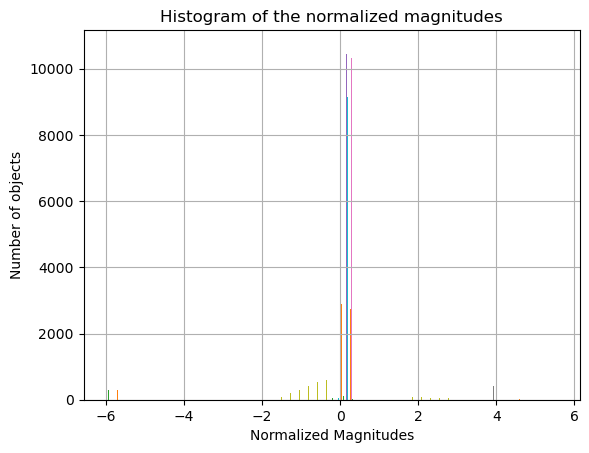

In [20]:
plt.hist(data, bins=100)
plt.xlabel('Normalized Magnitudes')
plt.ylabel('Number of objects')
plt.title('Histogram of the normalized magnitudes')
plt.grid()
plt.show()

# Running the SOM

In [17]:
%%time

som = sps.SOMNet(
    som_x*2,
    som_y*2,
    data,
    load_file = None,
    metric= 'euclidean', # 'euclidian' or 'cosine' or 'manhattan'
    # metrick_kwds={},
    init = 'random' , # 'random' or 'pca'
    PBC = True,
    GPU = False,
    random_seed = 42,
    topology='hexagonal', # 'square' or 'hexagonal'
    debug= True
)

som.train(
    train_algo = 'batch', 
    epochs = 200 ,
    start_learning_rate = 0.5 ,
    early_stop = None ,
    early_stop_patience = 5 ,
    early_stop_tolerance = 0.01 ,
    batch_size = -1
)

2025-04-17 12:32:43.831 | INFO     | simpsom.network:__init__:106 - Periodic Boundary Conditions active.
2025-04-17 12:32:43.832 | INFO     | simpsom.network:__init__:115 - Hexagonal topology.
2025-04-17 12:32:43.833 | INFO     | simpsom.network:_set_weights:191 - The weights will be initialized randomly.
2025-04-17 12:32:43.870 | INFO     | simpsom.network:train:374 - The map will be trained with the batch algorithm.
2025-04-17 12:32:43.873 | DEBUG    | simpsom.network:train:494 - Training SOM... 0.00%
2025-04-17 12:33:07.242 | DEBUG    | simpsom.network:train:494 - Training SOM... 5.00%
2025-04-17 12:33:30.845 | DEBUG    | simpsom.network:train:494 - Training SOM... 10.00%
2025-04-17 12:33:54.277 | DEBUG    | simpsom.network:train:494 - Training SOM... 15.00%
2025-04-17 12:34:18.115 | DEBUG    | simpsom.network:train:494 - Training SOM... 20.00%
2025-04-17 12:34:40.868 | DEBUG    | simpsom.network:train:494 - Training SOM... 25.00%
2025-04-17 12:35:04.511 | DEBUG    | simpsom.network

CPU times: user 1h 3min 31s, sys: 135 ms, total: 1h 3min 31s
Wall time: 7min 56s


In [18]:
som.save_map('/data/mfonseca/soms/emu_som_0102-32_200epochs_colors_2size.npy')

2025-04-17 12:40:54.211 | INFO     | simpsom.network:save_map:302 - Map shape and weights will be saved to:
/data/mfonseca/soms/emu_som_0102-32_200epochs_colors_2size.npy


## U-Matrix

/home/mfonseca/anaconda3/envs/rapids-25.02/lib/python3.12/site-packages/simpsom-3.0.0b0-py3.12.egg/simpsom/distances.py:178: RuntimeWarning: invalid value encountered in sqrt
  return self.xp.sqrt(squares_a + squares_b.T - 2 * a.dot(b.T))
2025-04-17 12:40:57.720 | INFO     | simpsom.network:get_nodes_difference:579 - Weights difference among neighboring nodes calculated.


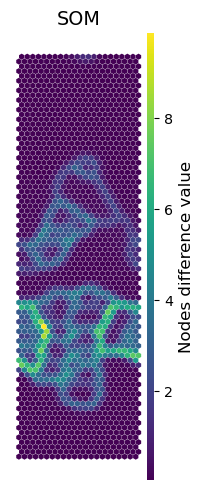

2025-04-17 12:40:58.202 | INFO     | simpsom.network:plot_map_by_difference:751 - Node difference map will be saved to:
././som_difference.png


In [19]:
som.plot_map_by_difference(show=True, print_out=True)

## Quantization Error (QE) and Topographic Error (TE)

In [ ]:
# Quantization Error (QE)
# Average distance of a data point to the nearest lattice node
# Measures how well the mapping fits the distribution of the data

def calculate_quantization_error(original_data, trained_som):
    '''
    Calculate the quantization error of the SOM.
    '''

    BMU_indices = trained_som.find_bmu_ix(original_data)

    return quantization_error

In [ ]:
# Topographic Error (TE)
# Measures how well the shape of the data is preserved in the output space

def calculate_topographic_error(original_data, trained_som):
    '''
    Calculate the topographic error of the SOM.

    Parameters:
    - data: numpy array of shape (n_samples, n_features)
    - som: trained sps.SOMNet object

    Returns:
    - topographic_error: float, topographic error of the SOM
    '''


    BMU_indices = trained_som.find_bmu_ix(original_data)

    sps.distances.Distance.euclidean_distance

    return topographic_error

## Component Planes

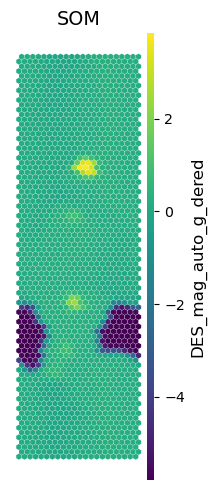

2025-04-17 12:45:53.133 | INFO     | simpsom.network:plot_map_by_feature:713 - Feature map will be saved to:
././som_feature_0.png


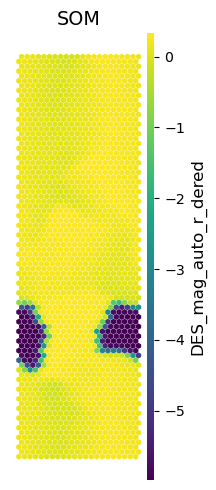

2025-04-17 12:45:53.589 | INFO     | simpsom.network:plot_map_by_feature:713 - Feature map will be saved to:
././som_feature_1.png


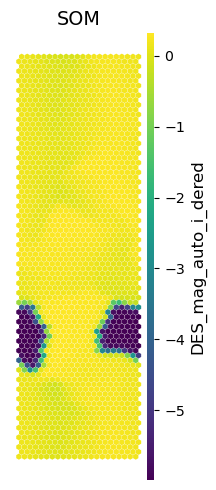

2025-04-17 12:45:54.140 | INFO     | simpsom.network:plot_map_by_feature:713 - Feature map will be saved to:
././som_feature_2.png


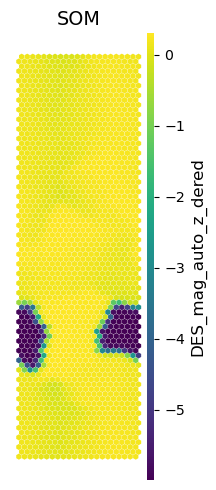

2025-04-17 12:45:54.596 | INFO     | simpsom.network:plot_map_by_feature:713 - Feature map will be saved to:
././som_feature_3.png


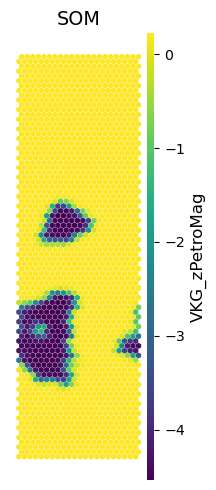

2025-04-17 12:45:55.047 | INFO     | simpsom.network:plot_map_by_feature:713 - Feature map will be saved to:
././som_feature_4.png


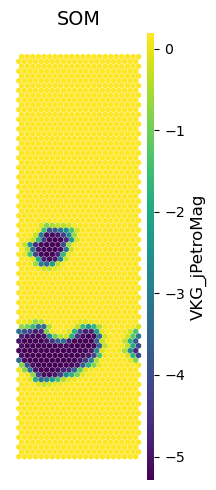

2025-04-17 12:45:55.598 | INFO     | simpsom.network:plot_map_by_feature:713 - Feature map will be saved to:
././som_feature_5.png


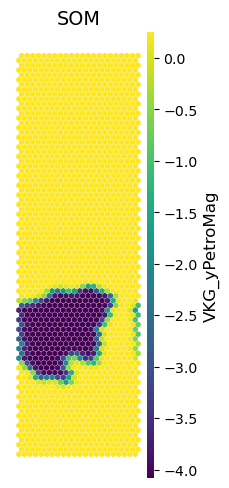

2025-04-17 12:45:56.074 | INFO     | simpsom.network:plot_map_by_feature:713 - Feature map will be saved to:
././som_feature_6.png


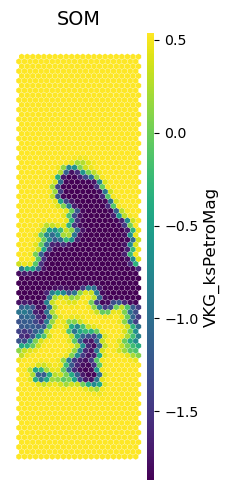

2025-04-17 12:45:56.528 | INFO     | simpsom.network:plot_map_by_feature:713 - Feature map will be saved to:
././som_feature_7.png


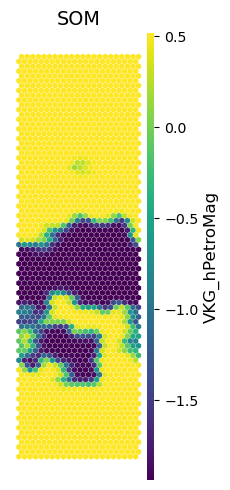

2025-04-17 12:45:57.076 | INFO     | simpsom.network:plot_map_by_feature:713 - Feature map will be saved to:
././som_feature_8.png


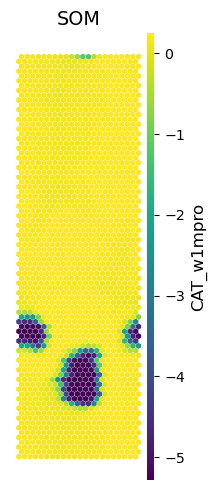

2025-04-17 12:45:57.529 | INFO     | simpsom.network:plot_map_by_feature:713 - Feature map will be saved to:
././som_feature_9.png


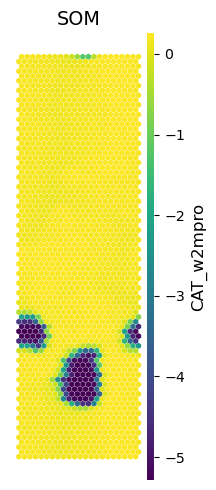

2025-04-17 12:45:57.985 | INFO     | simpsom.network:plot_map_by_feature:713 - Feature map will be saved to:
././som_feature_10.png


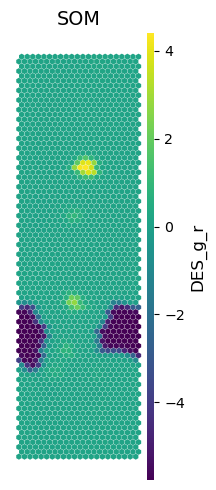

2025-04-17 12:45:58.516 | INFO     | simpsom.network:plot_map_by_feature:713 - Feature map will be saved to:
././som_feature_11.png


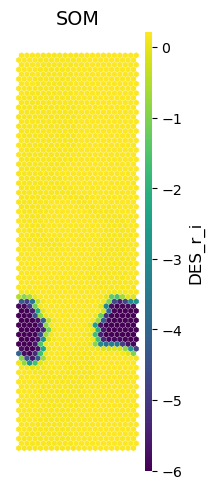

2025-04-17 12:45:58.975 | INFO     | simpsom.network:plot_map_by_feature:713 - Feature map will be saved to:
././som_feature_12.png


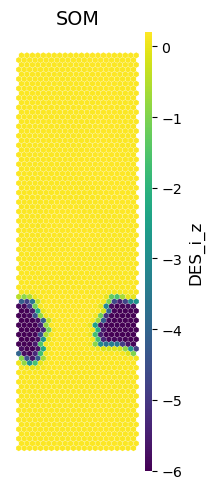

2025-04-17 12:45:59.528 | INFO     | simpsom.network:plot_map_by_feature:713 - Feature map will be saved to:
././som_feature_13.png


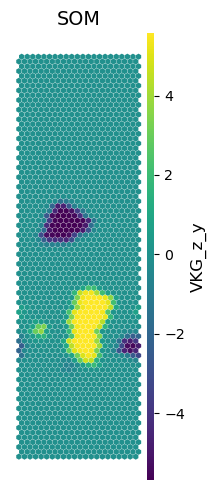

2025-04-17 12:45:59.974 | INFO     | simpsom.network:plot_map_by_feature:713 - Feature map will be saved to:
././som_feature_14.png


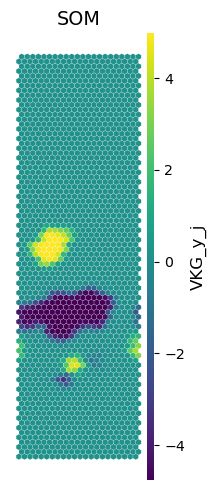

2025-04-17 12:46:00.410 | INFO     | simpsom.network:plot_map_by_feature:713 - Feature map will be saved to:
././som_feature_15.png


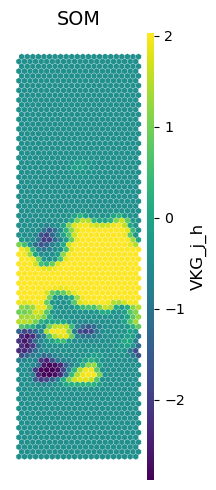

2025-04-17 12:46:00.946 | INFO     | simpsom.network:plot_map_by_feature:713 - Feature map will be saved to:
././som_feature_16.png


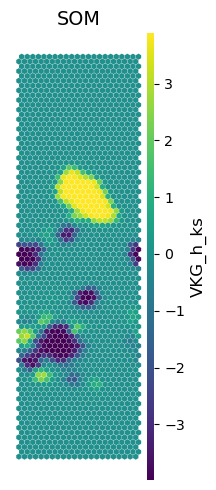

2025-04-17 12:46:01.406 | INFO     | simpsom.network:plot_map_by_feature:713 - Feature map will be saved to:
././som_feature_17.png


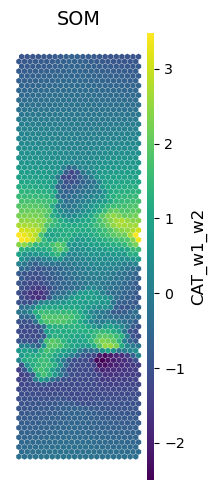

2025-04-17 12:46:01.864 | INFO     | simpsom.network:plot_map_by_feature:713 - Feature map will be saved to:
././som_feature_18.png


In [21]:
for i in range(len(catalog_filtered_magnitude.columns)):
    som.plot_map_by_feature(
        feature_ix= i,
        show=True,
        print_out=True,
        cbar_label=catalog_filtered_magnitude.columns[i],
    )

# XPySom

In [ ]:
data_min = catalog_matrix.min(axis=0)
data_max = catalog_matrix.max(axis=0)
normalized_data = (catalog_matrix - data_min) / (data_max - data_min)

In [ ]:
galaxy_names = catalog_df['EMU_island_name'].values

# data normalization
data = (catalog_df_filtered - np.mean(catalog_df_filtered, axis=0)) / np.std(catalog_df_filtered, axis=0)
data = data.values

# Initialization and training
som_shape = (20, 20)
som = XPySom(20, 20, data)


# MiniSom

### Example

In [ ]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt', 
                    names=['area', 'perimeter', 'compactness', 'length_kernel', 'width_kernel',
                   'asymmetry_coefficient', 'length_kernel_groove', 'target'], usecols=[0, 5], 
                   sep='\t+', engine='python')
# data normalization
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
data = data.values


# Initialization and training
som_shape = (1, 3)
som = MiniSom(som_shape[0], som_shape[1], data.shape[1], sigma=.5, learning_rate=.5,
              neighborhood_function='gaussian', random_seed=10)

som.train_batch(data, 500, verbose=True)

In [ ]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in data]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

In [ ]:
# plotting the clusters using the first 2 dimentions of the data
for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0],
                data[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# plotting centroids
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', 
                s=4, linewidths=10, color='k', label='centroid')
plt.legend(loc='best')

### With our galaxy values

In [ ]:
galaxy_names = catalog_df['EMU_island_name'].str.decode('utf-8').str.strip()

# Normalize the data
data = (catalog_df_filtered_matches_magnitude - np.mean(catalog_df_filtered_matches_magnitude, axis=0)) / np.std(catalog_df_filtered_matches_magnitude, axis=0)
data = data.values

In [ ]:
som_shape = (10, 10)
som = MiniSom(som_shape[0], som_shape[1], data.shape[1], sigma=.5, learning_rate=.1,
              neighborhood_function='gaussian', random_seed=0)

som.train_batch(data, 100000, verbose=True)

In [ ]:
plt.figure(figsize=(7, 7))
frequencies = som.activation_response(data)
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
plt.show()

In [ ]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in data]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

In [ ]:
# plotting the clusters using the first 2 dimentions of the data
for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0],
                data[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# plt.xlim(-.5,1)
# plt.ylim(-1,1)
